In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import animation
import matplotlib
rc('animation', html='jshtml')

2.2 a) Implement the cellular automaton traffic model with periodic boundary
conditions. Run it for parameters vmax=2 and p=0.5. (Plotting suggestions: plot
road on x-axis, time on y-axis and dots for the cars; for a movie plot symbols
running along the edge of a square or circle (don’t use radians for the
simulation though)). Allow the system to equilibrate before recording the
flow rate. Average the flow rate over multiple times to get more accurate
results. Run with different car densities (number of cars / road length). Plot
the flow rate versus the density. This plot is called the fundamental diagram.
Explain its qualitative shape. At what density do traffic jams begin to occur?

2.2 b) Now we will estimate the statistical accuracy. Take a road length of 50,
use 25 cars, vmax=2 and p=0.5. Run multiple simulations, for each collect the
flow rate over 100 time steps. Compute the standard error of the flow rate.
How many simulations do you need to get a standard error of 0.001? How
long does the equilibration need to be to get accurate results? Does the
equilibration time depend on how you choose the initial conditions?

2.2 c) When do the results, i.e. the fundamental diagram, become
independent of road length? Or conversely, when shortening the road
length, when do the results start to deviate from those of long road
lengths? Be aware that longer roads need longer equilibration times.

2.2 d) For a fixed road length, compare your results for vmax=1 with
your results for vmax=2. Also consider vmax=5. Are there any quantitative
differences in the behavior of the cars?

2.2 e) Explore the effect of the speed reduction probability by
considering p=0.2 and p=0.8.
Tip: you can compute the (periodic) distance dn of car n to car n+1 as:
 dn = (posn+1 - posn + road_length) % road_length

In [2]:
def step_cellular_automata(X,V,vmax=2,p=0.5, roadLength=50):
    # Updates all cars according to rules provided in pdf.
    # Rule 1
    V[:] = np.where(V<vmax, V+1,V)

    # Rule 2
    if not len(X) == 1:
        X2 = np.delete(np.append(X,X[0]),0)
        dn = lambda a, b: (a - b + roadLength) % roadLength
        D = np.fromiter(map(dn, X2, X), dtype=np.float)
        V[:] = np.where(V >= D, D-1, V)

    # Rule 3
    PP = np.random.random(len(V))
    V[:] = np.where(PP<p, V-1, V)
    V[:] = np.where(V<0, 0, V)

    # Rule 4
    X[:] = X + V
    
    

In [3]:
def calcFlowRate(V, roadLength=50):
    # Calculates the flow rate
    return np.sum(V) / roadLength

In [4]:
# Move step() and calcflowrate() here
def run_m_simulations(nc=25, M=100, N=100,Nmax=300,roadLength=50, vmax=2, p=0.5):
    """
        - N     = Number of collected positions for each simulation
        - Nmax  = Number of step() iterations
        - M     = Number of simulations
        - nc    = Number of cars
    """

    FlowRates = np.zeros(M)
    for k in range(M):
        FR = np.zeros(Nmax) # Flow rates
        # Initial conditions:
        X = np.linspace(0,roadLength*(1-1/nc),nc,dtype=np.int)
        V = np.zeros(nc)

        # Run Nmax steps
        for i in range(Nmax):
            step_cellular_automata(X, V, vmax, p, roadLength)
            FR[i] = calcFlowRate(V, roadLength)

        # Add mean of N last flowrates
        FlowRates[k] = np.mean(FR[-N:])

    return FlowRates

In [10]:
# 2.2 a)
# - Create fundamental diagram for a plot

# parameters for a)
pa = {'vmax'      :2.0,
      'p'         :0.5,
      'roadLength':100,
      'numCars'   :np.arange(1,100+1),
      'n_of_sims' :50}

FR_a    = np.zeros(pa['roadLength'])
Dens_a  = pa['numCars']/pa['roadLength']

for i in range(pa['roadLength']):
    FR_a[i] = np.mean(run_m_simulations(pa['numCars'][i], M=pa['n_of_sims'], 
                                roadLength=pa['roadLength']))

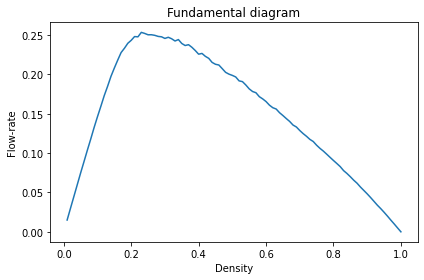

In [11]:
# Plot 2.2 a)
plt.figure()
plt.title(f"Fundamental diagram")
plt.xlabel('Density')
plt.ylabel("Flow-rate")
plt.plot(Dens_a, FR_a)
plt.tight_layout()  # adapt the plot area tot the text with larger fonts
plt.show()

In [20]:
# 2.2b)
# Determine statistical accuracy: plot standard error. (+ std + mean)

pa = {'vmax'      :2.0,
      'p'         :0.5,
      'roadLength':50,
      'numCars'   :25,
      'n_of_sims' :1000}

FRb = run_m_simulations(pa['numCars'], M=pa['n_of_sims'], 
                       roadLength=pa['roadLength'], Nmax=100)

C:\Users\Simon\AppData\Local\Temp/ipykernel_17040/649595982.py:3: RuntimeWarning: invalid value encountered in double_scalars
  STEb = np.array([np.sqrt(np.var(FRb[:i+1])/i) for i in range(pa['n_of_sims'])])


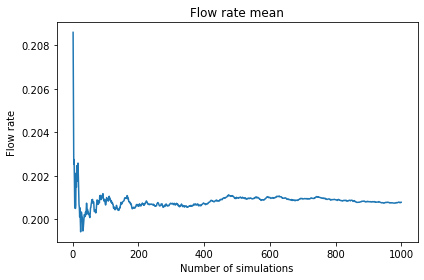

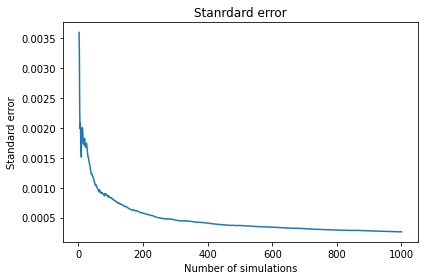

We have the desired error of s = 0.001 at N = 58
STE[1000] = 0.000261964084984606


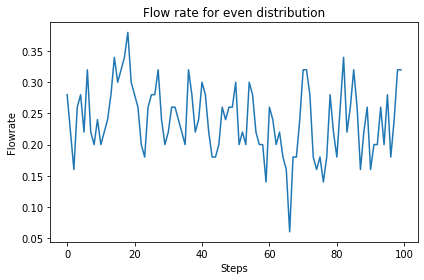

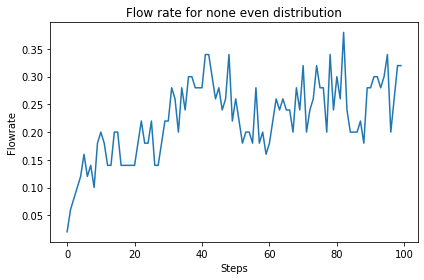

We can see that it takes roughly 20 steps for it to stabilize. If the cars are evenly distributed they have reached equilibrium from the start.


In [22]:
# Plot 2b)
MEANb = np.array([np.mean(FRb[:i+1]) for i in range(pa['n_of_sims'])])
STEb = np.array([np.sqrt(np.var(FRb[:i+1])/i) for i in range(pa['n_of_sims'])])

plt.figure()
plt.title("Flow rate mean")
plt.xlabel('Number of simulations')
plt.ylabel('Flow rate')
plt.plot(np.arange(1,pa['n_of_sims']+1), MEANb)
plt.tight_layout()  # adapt the plot area tot the text with larger fonts
plt.show()

plt.figure()
plt.title("Stanrdard error")
plt.xlabel('Number of simulations')
plt.ylabel('Standard error')
plt.plot(np.arange(1,pa['n_of_sims']+1), STEb)
plt.tight_layout()  # adapt the plot area tot the text with larger fonts
plt.show()

DESIRED_STE = 0.001
idxb = (np.abs(STEb[1:] - DESIRED_STE)).argmin()
print(f"We have the desired error of s = {DESIRED_STE} at N = {idxb+2}")
print(f"STE[1000] = {STEb[-1]}")

Nmaxb   = 100
ncb     = 20
# TODO: Plot flowrate v time
FRb1 = np.zeros(Nmaxb)
Xb1 = np.linspace(0,pa['roadLength']*(1-1/ncb),ncb,dtype=np.int)
Vb1 = np.zeros(ncb)
for i in range(Nmaxb):
    step_cellular_automata(Xb1, Vb1, 2, 0.5, 50)
    FRb1[i] = calcFlowRate(Vb1, 50)

plt.figure()
plt.title("Flow rate for even distribution")
plt.xlabel('Steps')
plt.ylabel('Flowrate')
plt.plot(np.arange(Nmaxb), FRb1)
plt.tight_layout()  # adapt the plot area tot the text with larger fonts
plt.show()

# TODO: Plot flowrates v time for different initial conditions.
FRb2 = np.zeros(Nmaxb)
Xb2 = np.arange(ncb)
Vb2 = np.zeros(ncb)
for i in range(Nmaxb):
    step_cellular_automata(Xb2, Vb2, 2, 0.5, 50)
    FRb2[i] = calcFlowRate(Vb2, 50)

plt.figure()
plt.title("Flow rate for none even distribution")
plt.xlabel('Steps')
plt.ylabel('Flowrate')
plt.plot(np.arange(Nmaxb), FRb2)
plt.tight_layout()  # adapt the plot area tot the text with larger fonts
plt.show()
print("We can see that it takes roughly 20 steps for it to stabilize. If the cars are evenly distributed they have reached equilibrium from the start.")

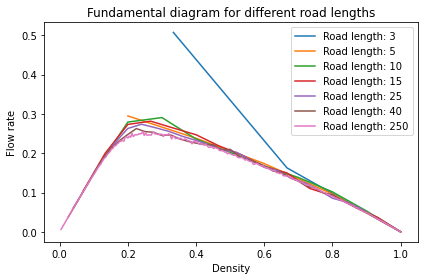

In [31]:
# 2.2c)
# - Create fundamental diagram for different road lengths
def get_fundamental_diagram(roadLength=100, vmax=2, p=0.5):
    pa = {'vmax'    :vmax,
        'p'         :p,
        'roadLength':roadLength,
        'numCars'   :np.arange(1,roadLength+1),
        'n_of_sims' :5}

    FR_a    = np.zeros(pa['roadLength'])
    Dens_a  = pa['numCars']/pa['roadLength']

    for i in range(pa['roadLength']):
        FR_a[i] = np.mean(run_m_simulations(pa['numCars'][i], M=pa['n_of_sims'], 
                                    roadLength=pa['roadLength'], vmax=vmax, p=p))
        
    return FR_a, Dens_a

plt.figure()
plt.title("Fundamental diagram for different road lengths")
plt.xlabel('Density')
plt.ylabel("Flow rate")
ROADLENGTH = [3, 5, 10, 15, 25, 40, 250]
FRc = [0]*len(ROADLENGTH)
DENSc = [0]*len(ROADLENGTH)
for i in range(len(ROADLENGTH)):
    FRc[i], DENSc[i] = get_fundamental_diagram(ROADLENGTH[i])
    plt.plot(DENSc[i], FRc[i], label=f"Road length: {ROADLENGTH[i]}")
plt.tight_layout()  # adapt the plot area tot the text with larger fonts
plt.legend()
plt.show()

C:\Users\Simon\AppData\Local\Temp/ipykernel_17040/2172783606.py:20: RuntimeWarning: invalid value encountered in double_scalars
  STEds[j] = np.array([np.sqrt(np.var(FRds[j][:i+1])/i) for i in range(len(FRds[j]))])
C:\Users\Simon\AppData\Local\Temp/ipykernel_17040/2172783606.py:20: RuntimeWarning: invalid value encountered in double_scalars
  STEds[j] = np.array([np.sqrt(np.var(FRds[j][:i+1])/i) for i in range(len(FRds[j]))])
C:\Users\Simon\AppData\Local\Temp/ipykernel_17040/2172783606.py:20: RuntimeWarning: invalid value encountered in double_scalars
  STEds[j] = np.array([np.sqrt(np.var(FRds[j][:i+1])/i) for i in range(len(FRds[j]))])
C:\Users\Simon\AppData\Local\Temp/ipykernel_17040/2172783606.py:20: RuntimeWarning: invalid value encountered in double_scalars
  STEds[j] = np.array([np.sqrt(np.var(FRds[j][:i+1])/i) for i in range(len(FRds[j]))])


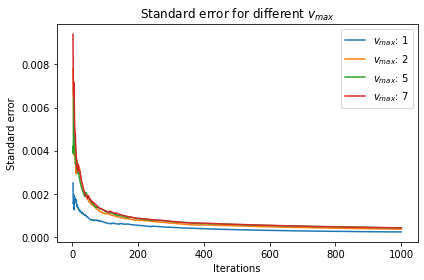

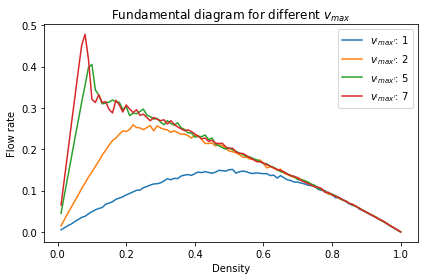

In [43]:
# d)
""" Plot with vmax=1,2,5:
        - Fundamental diagram
        - Variance
        - Dependance on roadlength
"""

vmaxd = np.array([1,2,5, 7])
FRds = [0]*4
STEds = [0]*4
numCarsd = 20

# Following calculates variance
plt.figure()
plt.title(r"Standard error for different $v_{max}$")
plt.xlabel('Iterations')
plt.ylabel('Standard error')
for j in range(4):
    FRds[j] = run_m_simulations(numCarsd, M=1000, vmax=vmaxd[j])
    STEds[j] = np.array([np.sqrt(np.var(FRds[j][:i+1])/i) for i in range(len(FRds[j]))])
    plt.plot(np.arange(1,len(FRds[j])+1), STEds[j], label=r"$v_{max}$: " + str(vmaxd[j]))
plt.tight_layout()
plt.legend()
plt.show()
# Following gets fundamental diagram


# FRc[i], DENSc[i] = get_fundamental_diagram(ROADLENGTH[i])

plt.figure()
plt.title(r"Fundamental diagram for different $v_{max}$")
plt.xlabel('Density')
plt.ylabel("Flow rate")
FRd2 = [0]*len(vmaxd)
DENSd2 = [0]*len(vmaxd)
for i in range(len(vmaxd)):
    FRd2[i], DENSd2[i] = get_fundamental_diagram(vmax=vmaxd[i])
    plt.plot(DENSd2[i], FRd2[i], label=r"$v_{'max'}$: "+ str(vmaxd[i]))
plt.tight_layout()  # adapt the plot area tot the text with larger fonts
plt.legend()
plt.show()


C:\Users\Simon\AppData\Local\Temp/ipykernel_17040/3801061048.py:21: RuntimeWarning: invalid value encountered in double_scalars
  STEes[j] = np.array([np.sqrt(np.var(FRes[j][:i+1])/i) for i in range(len(FRes[j]))])
C:\Users\Simon\AppData\Local\Temp/ipykernel_17040/3801061048.py:21: RuntimeWarning: invalid value encountered in double_scalars
  STEes[j] = np.array([np.sqrt(np.var(FRes[j][:i+1])/i) for i in range(len(FRes[j]))])
C:\Users\Simon\AppData\Local\Temp/ipykernel_17040/3801061048.py:21: RuntimeWarning: invalid value encountered in double_scalars
  STEes[j] = np.array([np.sqrt(np.var(FRes[j][:i+1])/i) for i in range(len(FRes[j]))])


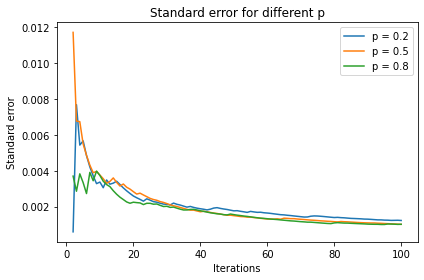

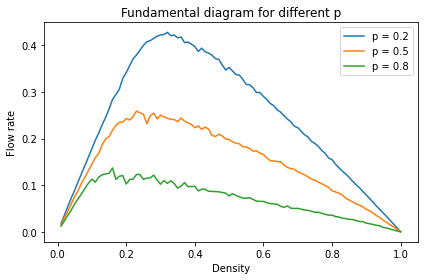

In [45]:
# e)
""" Same as above but with p=0.2,0.5,0.8
"""
""" Plot with p=0.2,0.5,0.8:
        - Fundamental diagram
        - Variance
"""

pe2 = np.array([0.2,0.5,0.8])
FRes = [0]*3
STEes = [0]*3
numCarse = 20

# Following calculates variance
plt.figure()
plt.title("Standard error for different p")
plt.xlabel('Iterations')
plt.ylabel('Standard error')
for j in range(3):
    FRes[j] = run_m_simulations(numCarse, M=100, p=pe2[j])
    STEes[j] = np.array([np.sqrt(np.var(FRes[j][:i+1])/i) for i in range(len(FRes[j]))])
    plt.plot(np.arange(1,len(FRes[j])+1), STEes[j], label=f"p = {pe2[j]}")
plt.tight_layout()
plt.legend()
plt.show()
# Following gets fundamental diagram


# FRc[i], DENSc[i] = get_fundamental_diagram(ROADLENGTH[i])

plt.figure()
plt.title(f"Fundamental diagram for different p")
plt.xlabel('Density')
plt.ylabel("Flow rate")
FRe2 = [0]*len(pe2)
DENSe2 = [0]*len(pe2)
for i in range(len(pe2)):
    FRe2[i], DENSe2[i] = get_fundamental_diagram(p=pe2[i])
    plt.plot(DENSe2[i], FRe2[i], label=f"p = {pe2[i]}")
plt.tight_layout()  # adapt the plot area tot the text with larger fonts
plt.legend()
plt.show()

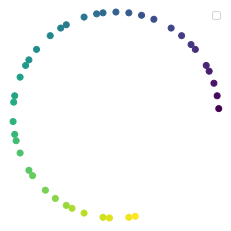

In [49]:
# Example for simple animation of cars on a circular road

roadLength    = 100
numCars       = 40
numFrames     = 500
vmax          = 2
p             = 0.5

# positions = np.linspace(0, roadLength*(1-1/numCars), numCars, dtype=np.float)
positions = np.arange(numCars, dtype=np.float)*2
theta = np.zeros(numCars)
r = np.ones(numCars)
color = np.arange(numCars)

velocity = np.zeros(numCars)
v2str = lambda v: f"V = {v}"

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='polar')
ax1.axis('off')
labels = list(map(v2str, velocity))
ax1.legend(labels)

def animate(frameNr):
    ax1.clear()
    ax1.axis('off')
    step_cellular_automata(positions, velocity, vmax, p, roadLength)
    labels = list(map(v2str, velocity))
    ax1.legend(labels)

    for i in range(numCars):
        # positions[i] += 1
        # Convert to radians for plotting  only (do not use radians for the simulation!)
        theta[i] = positions[i] * 2 * np.pi / roadLength
    
    return ax1.scatter(theta, r, c=color), 

# Call the animator, blit=True means only re-draw parts that have changed
anim = animation.FuncAnimation(fig, animate,
                               frames=numFrames, interval=25, blit=True, repeat=True)
plt.show()

In [50]:
anim

In [48]:
writergif = animation.PillowWriter(fps=16)
anim.save(f"withjams.gif", writer=writergif)